# Using Amazon SageMaker to learn how weather can influence urban air quality


## Introduction
Air pollution in cities can be an acute problem leading to damaging effects on people, animals, plants and property. It is an important topic which is getting increased attention as the human population of cities continues to increase. This year it was the subject the [2018 KDD Cup](http://www.kdd.org/kdd2018/kdd-cup), the annual data mining and knowledge discovery competition organized by ACM SIGKDD

The burning of fossil fuels for transport and home heating is a major contributor to air pollution in urban environments, creating the pollutant nitrogen dioxide (NO<sub>2</sub>). This is a secondary pollutant produced by the oxidation of NO. It is a major contributor to respiratory problems.  In the European Union, the Cleaner Air For Europe (CAFÉ) Directive 2008/50/EC established an hourly limit of 200 μg/m<sup>3</sup> and an annual mean limit of 40 μg/m<sup>3</sup> in respect of NO<sub>2</sub>. No more than 18 exceedances of the hourly limit values are allowed per year. 

Many cities around the globe report on the air quality levels at least on a daily basis. We decided to look into air quality data by using Amazon SageMaker, a fully-managed platform that enables developers and data scientists to quickly and easily build, train, and deploy machine learning models at any scale. 


## The Scenario
For the demonstration in this notebook, we examine the relationship between an air pollutant (NO<sub>2</sub>) and weather in a selected city: Dublin, Ireland. 

The air quality data comes from a long established monitoring station run by the Irish Environmental Protection Agency. The station is located in Rathmines, Dublin, Ireland. Rathmines is an inner suburb of Dublin, about 3 kilometers south from the city center.  Dublin, the capital city of the Republic of Ireland, has a population of approximately one million people. The city is bounded by the sea to the east, mountains to the south, and flat topography to the west and north. The mountains to the south of Dublin affect the wind speed and direction over the city. When the general flow of wind is from the south the mountains deflect the flow to a south-westerly or south-easterly direction.

The weather data comes from the long established weather station located at Dublin Airport. Dublin Airport is located on the flat topography to the north of the city. It is about 12 kilometers north of Dublin city center.


## The Tools
* Amazon SageMaker for exploratory data analysis and machine learning. 
* Amazon Simple Storage Service (Amazon S3) to stage the data for analysis. 

## The Data
Hourly air pollution datasets for the Rathmines monitoring station are published by the Irish Environmental Protection Agency. The data we used spans the years 2011 to 2016. This data is available as Open Data. The provenance of the data is described at the following link, and data can also be downloaded at this link:

http://erc.epa.ie/

A daily weather data set for Dublin Airport stretching back to 1942 is published by the Irish Meteorological Service (Met. Eireann) on their website under a Creative Commons License.

https://www.met.ie/climate/available-data/historical-data

In this notebook, we will be using these two data sets to perform our analysis and build a predictive model. 

For global studies, there is a handy repository of air quality data available on [OpenAQ](https://openaq.org) this data is also available via [Registry of Open Data on AWS](https://registry.opendata.aws/openaq/).


## The Method

### Step One: Data Collection

The data is in CSV format. Before we put the data into our Amazon S3 bucket, we carried out some data wrangling to prepare it for analysis:

#### Prepaing the data for analysis and loading data from Amazon S3
The data is in CSV format. Before we put the data into our Amazon S3 bucket, we carried out some data wrangling to prepare it for analysis:
 - Weather Data: The data set contained more information than we needed for the purpose of this proof of concept. To prepare the weather data the following actions with the original dataset were carried out:
     - Removed the header, this takes up the first 25 rows of the dataset.
     - Converted measurement unit for wind speed from knots to meters per second.
     - Selected a subset of the parameters available. Parameters were chosen based on results from scientific papers on this subject.
     - The names of the parameters selected were changed to reduce ambiguity.
         - ‘rain’ became ‘rain_mm’.  The precipitation amount in mm.
         - ‘maxtp’ became ‘maxtemp’. The maximum air temperature in celcius.
         - ‘mintp’ became ‘mintemp’. The minimum air temperature in celcius.
         -‘cbl’  became ‘pressure_hpa. The mean air pressure in hectopascals.
         - ‘wdsp’ became ‘wd_speed_m_per_s’ (and the units converted from knots).
         - ‘ddhm’ became ‘winddirection’.
         - ‘sun’ became ‘sun_hours’ The sunshine duration.
         - ‘evap’ became ‘evap_mm’. Evaporation (mm).
 - Air Quality Data: Each year of air quality data came in separate files and the units used to measure the pollutants changed from standard units (SI) to an obsolete unit. We decided to only use the years where the SI units are used, this limited us to a time period of 2011 to 2016. These yearly files were merged into one file. 
 - Sample Rate: The weather observations are 24-hour daily averages, and the air quality data came as 1-hour averages. We resampled the air quality data to 24-hour averages and changed the parameter name to indicate this. For example NO<sub>2</sub> became NO2_avg.
 
After this preliminary data transformation, we published the new data in our S3 bucket. We are now ready to look into the data by using the notebook-hosting capabilities of Amazon SageMaker.

### Step Two: Preparing Amazon SageMaker 

When opening a SageMaker notebook, we load the relevant libraries into the notebook:

In [10]:
import os
import boto3
import re
import json
import sagemaker
from sagemaker import get_execution_role, session

sm_session = sagemaker.Session()
region = sm_session.boto_region_name

role = get_execution_role()
print("Role ARN: {}".format(role))

bucket = "sagemaker-model-monitor-praveena"
print("Demo Bucket: {}".format(bucket))
prefix = "sagemaker/DEMO-ModelMonitor"

data_capture_prefix = "{}/datacapture".format(prefix)
s3_capture_upload_path = "s3://{}/{}".format(bucket, data_capture_prefix)
reports_prefix = "{}/reports".format(prefix)
s3_report_path = "s3://{}/{}".format(bucket, reports_prefix)

print("Capture path: {}".format(s3_capture_upload_path))
print("Report path: {}".format(s3_report_path))

Role ARN: arn:aws:iam::648739860567:role/sagemaker-ecs-admin
Demo Bucket: sagemaker-model-monitor-praveena
Capture path: s3://sagemaker-model-monitor-praveena/sagemaker/DEMO-ModelMonitor/datacapture
Report path: s3://sagemaker-model-monitor-praveena/sagemaker/DEMO-ModelMonitor/reports


In [11]:
%matplotlib inline
import pandas as pd
from datetime import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15, 5]

# To remove the pandas warning
pd.options.mode.chained_assignment = None


Those libraries will help us analyze the data using pandas, a popular data manipulation tool, as well as numpy, the de-facto scientific library in Python. Seaborn and matplotlib are used to power our visualisations. 

#### Loading prepared data into Amazon SageMaker from Amazon S3
Now that we have the notebook ready for use with the right libraries imported, we can import the data. For this, we will use the pandas library, which is great for exploring and massaging tabular data directly in Python. We can use the **pandas.read_csv** command, supplying it with the location of our data in S3. For both the air pollution and weather data, we changed the column names to something more readable (see the following code, for an air pollution example). We also had to create our own date parser, due to the specific format use for dates in the data.

In [12]:
def parse(x):
    return datetime.strptime(x, '%d-%b-%y')

In [13]:
#Air Pollution Data
col_names = ['daily_avg', 'nox_avg', 'no_avg', 'no2_avg']
nox_df = pd.read_csv('https://s3.amazonaws.com/aws-machine-learning-blog/artifacts/air-quality/Dublin_Rathmines_NOx_2011_2016_ugm3_daily.csv',  
                    date_parser=parse,
                    parse_dates=['Daily_Avg'])
nox_df.columns = col_names

To ease the filtering of the data frames we set the index of the air pollution data frame.

In [14]:
#Setting date as the index
nox_df = nox_df.set_index('daily_avg')

# Print some records in the nox_df
nox_df.head()

,nox_avg,no_avg,no2_avg
daily_avg,,,
2011-01-01,26.37,2.42,22.67
2011-01-02,40.04,4.70,32.86
2011-01-03,37.46,3.82,31.62
2011-01-04,15.76,1.77,13.05
2011-01-05,29.40,3.09,24.67


In [15]:
#Now the weather data
weather_col_names = ['observation_date', 'maxtemp', 'mintemp', 'rain_mm', 'pressure_hpa', 'wd_speed_m_per_s', 'wind_direction', 'sun_hours', 'g_rad', 'evap_mm']
weather_df = pd.read_csv('https://s3.amazonaws.com/aws-machine-learning-blog/artifacts/air-quality/DublinAirportWeatherStationDerived_1942_to_2018.csv', 
                    date_parser=parse,
                    parse_dates=['date'])
weather_df.columns = weather_col_names

An initial check of the weather data revealed a problem with the imported dates. For example, 1945 was imported as 2045, this was fixed using the following piece of code

In [16]:
# The weather data should be from 1942, not 2042
from datetime import datetime
from dateutil.relativedelta import relativedelta

def convert_date_to_right_century(dt):
    if dt > datetime.now():
        dt -= relativedelta(years=100)
    return dt

weather_df['observation_date'] = weather_df['observation_date'].apply(convert_date_to_right_century)

#Set the date to be the index of the data frame.
weather_df = weather_df.set_index('observation_date')

# Quick look in the weather dataset
weather_df.head()

,maxtemp,mintemp,rain_mm,pressure_hpa,wd_speed_m_per_s,wind_direction,sun_hours,g_rad,evap_mm
observation_date,,,,,,,,,
1942-01-01,9.7,6.8,0.0,1020.3,8.9,,0.0,,1.4
1942-01-02,9.9,7.9,0.1,1016.2,7.8,,0.0,,0.9
1942-01-03,11.2,8.9,1.5,1006.8,7.2,,0.1,,0.6
1942-01-04,9.2,2.7,3.5,1001.5,8.8,,0.6,,0.7
1942-01-05,3.5,-0.8,0.6,1013.4,6.7,,3.4,,0.7


Now that we have loaded both datasets and got a quick look into them, let's explore the datasets into more details. 

## Step Three: Exploratory data analysis (EDA) – Data cleaning and exploration

*Exploratory data analysis* is the attempt to summarize the date through visualizations or summary statistics before performing any statistical modelling on a data set. You can use EDA to get a general understanding of the data structure and validity. If possible it is also valuable to get a general overview of what associations might exist between datasets, which will guide us in building the right predictive model based on the data particularities. 

#### Cleaning the Data
Initial graphs of the air pollution showed that there was a problem in 2014 with negative readings of pollution concentrations for all the oxides of nitrogen. This is an impossible situation which was probably due to a sensor calibration error at the air quality monitoring station.

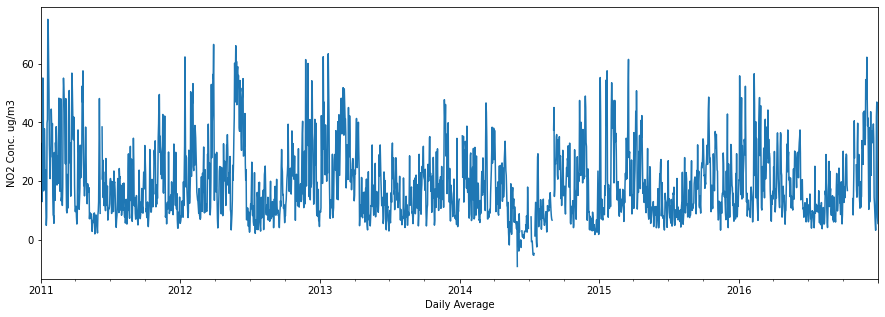

In [17]:
nox_df['no2_avg'].plot()
plt.ylabel('NO2 Conc. ug/m3')
plt.xlabel('Daily Average')
plt.show()

**Figure:** The complete Nitrogen Dioxide dataset. Notice the dip in the middle of 2014.

When we studied this data in more detail, we noticed gaps in the data for 2014, as shown in the following graph.

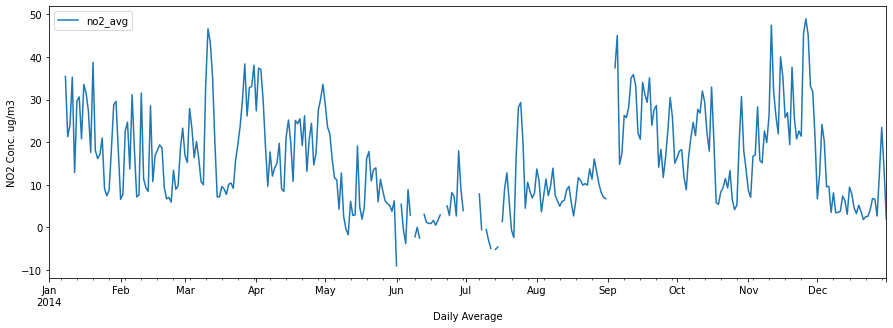

In [18]:
# Filter the data for the year 2014 and graph it
nox_df.loc['2014-01-01':'2014-12-31', ['no2_avg']].plot()
plt.ylabel('NO2 Conc. ug/m3')
plt.xlabel('Daily Average')
plt.show()

**Figure:** Gaps in the 2014 data set.

If there are gaps in 2014, it was reasonable to assume that there are gaps in other years as well. To fix this, we linearly interpolated over the whole data set the [time](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.interpolate.html) method.

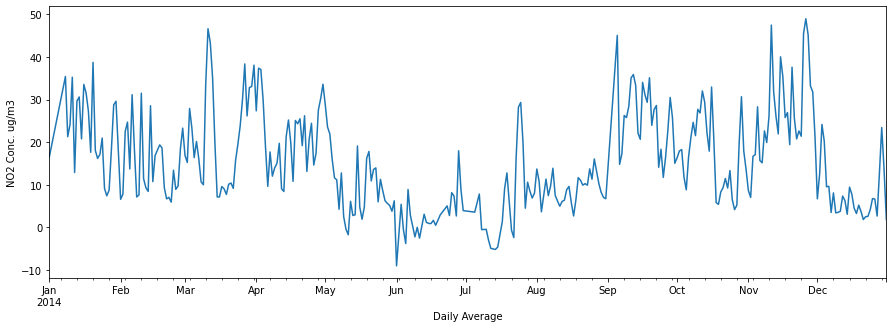

In [19]:
# Interporlate over the whole data set to fill data gaps.
nox_df = nox_df.interpolate(method='time')

# Now have a look at 2014 again
nox_df['2014-01-01':'2014-12-31']['no2_avg'].plot()
plt.ylabel('NO2 Conc. ug/m3')
plt.xlabel('Daily Average')
plt.show()

**Figure:** Gaps in the 2014 data set have been filled.

For the purposes of this exercise, we fixed the sensor drift in 2014 by simply replacing the spurious values. We decided to replace values that are less than 0 with 5


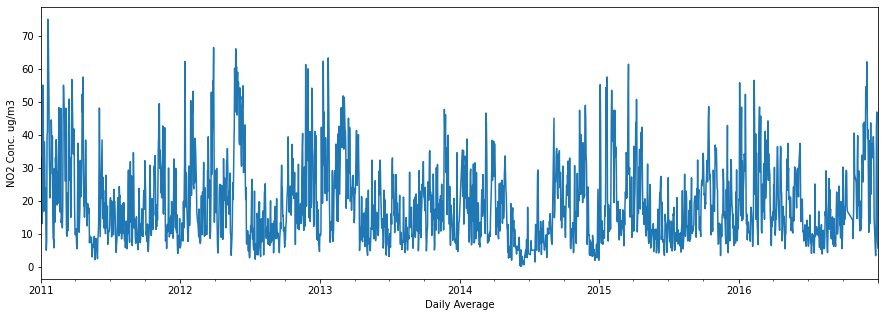

In [20]:
# Replace all values that are less than 0 with 5.
nox_df["no2_avg"] = nox_df["no2_avg"].apply(lambda x: 5 if x <= 0 else x)

# Plot the result
nox_df['no2_avg'].plot()
plt.ylabel('NO2 Conc. ug/m3')
plt.xlabel('Daily Average')
plt.show()

**Figure:** The fixed Nitrogen Dioxide dataset.

### Visualizing some key insights of the data
All visualizations were produced within Amazon SageMaker using the open source Python matplotlib library.

The first visualization is a figure of boxplots of NO<sub>2</sub> concentrations for each year, 2011 to 2016. A boxplot is a great way to understand the spread of the data. In this plot:

* The box is Q3 - Q1. Q1 (first quartile) is the middle value between the lowest value and the median. Q3 is the middle value between the highest value and the median
* The bar across the box is the median value
* The whiskers are 1.5 Q3 - Q1 from the edges of the box
* The dots beyond the whiskers are the outliers

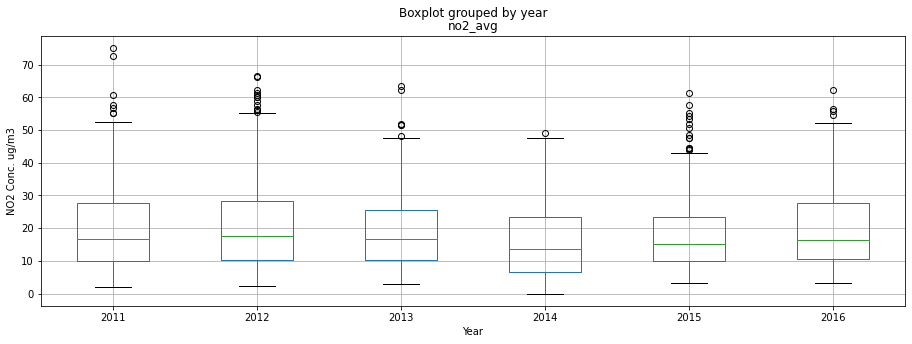

In [21]:
new_df = nox_df[['no2_avg']]
new_df['year'] = pd.DatetimeIndex(new_df.index).year
new_df.boxplot(by='year')
plt.ylabel('NO2 Conc. ug/m3')
plt.xlabel('Year')

plt.show()

**Figure:** Boxplots of NO<sub>2</sub> concentrations for each year of study.

From the figure we can see that there is some variation over the years but that the main body of the data (the box) stays within the range of 10 to 30 µg/m<sup>3</sup>. 

The number of extreme values (values outside the whiskers) vary from year to year which seems to fit with the idea of pollution episodes being linked to unusual events. It is also clear that 2014 data problems have distorted the distribution of the 2014 data.

To be able to get more insights, we'll create a single merged dataframe between the weather and NO<sub>2</sub> data.

In [22]:
#Create a new data frame containing the weather data for sames time period of the air quality data.
new_weather_df = weather_df['2011-01-01':'2016-12-31']
new_weather_df[['wind_direction']] = new_weather_df[['wind_direction']].apply(pd.to_numeric)

In [23]:
# Select only the parameters we want.
weather_sub_df = new_weather_df[['maxtemp','wd_speed_m_per_s','wind_direction','pressure_hpa','sun_hours']]

In [24]:
# Create a data frame only containing NO2 data and merge it with our new weather data frame
no2_df = nox_df[['no2_avg']]
comp_df = pd.merge(weather_sub_df,no2_df, left_index=True, right_index=True)
comp_df.head()

,maxtemp,wd_speed_m_per_s,wind_direction,pressure_hpa,sun_hours,no2_avg
observation_date,,,,,,
2011-01-01,7.8,4.2,350,1017.8,1.1,22.67
2011-01-02,3.1,3.1,50,1019.5,0.0,32.86
2011-01-03,2.7,3.4,240,1012.4,2.5,31.62
2011-01-04,5.4,8.4,260,997.2,0.0,13.05
2011-01-05,5.8,7.1,240,984.1,4.6,24.67


Now that we have our dataset containing both weather and NO<sub>2</sub> data, we can produce some scatter plots of meteorological parameters against NO<sub>2</sub> concentrations to understand the relationship between the parameters.

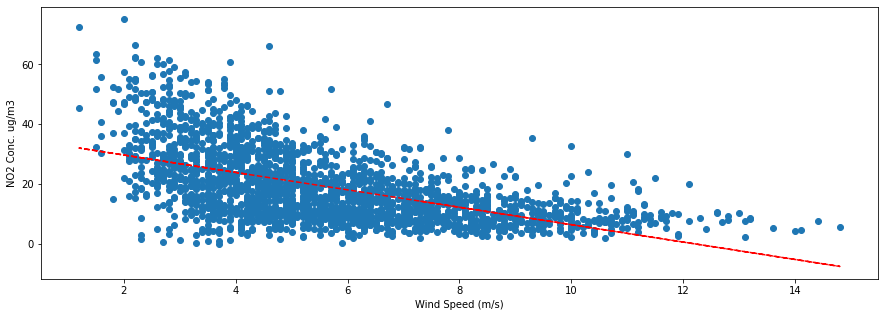

In [25]:
mydata = comp_df[['wd_speed_m_per_s','no2_avg']]

x = mydata['wd_speed_m_per_s']
y = mydata['no2_avg']
plt.scatter(x, y)

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.ylabel('NO2 Conc. ug/m3')
plt.xlabel('Wind Speed (m/s)')
plt.show()

plt.show()

**Figure:** Wind speed versus  NO<sub>2</sub> concentration. As wind speed increases pollution concentration decreases.

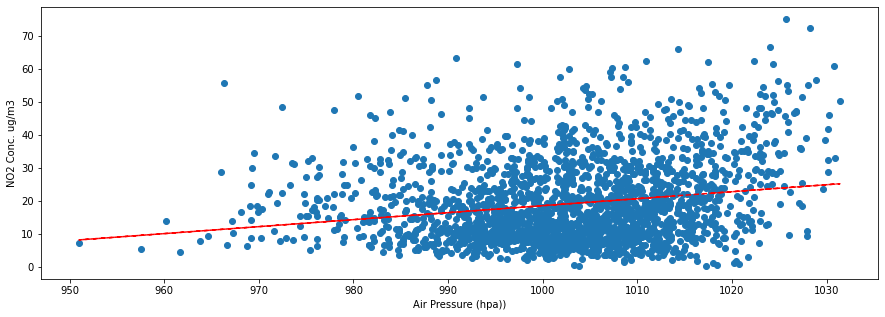

In [26]:
mydata = comp_df[['pressure_hpa','no2_avg']]

x = mydata['pressure_hpa']
y = mydata['no2_avg']
plt.scatter(x, y)

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.ylabel('NO2 Conc. ug/m3')
plt.xlabel('Air Pressure (hpa))')
plt.show()

plt.show()

**Figure:** Atmopsheric pressure versus NO<sub>2</sub> concentration. As atmospheric pressure increases so do the concentrations of NO<sub>2</sub>.

The above scatter plots led to the following observations:
* Wind Speed: As wind speed increases NO<sub>2</sub> concentrations in the atmopshere go down. 
* Atmopheric: As atmospheric pressure increases so does the concentration of NO<sub>2</sub> in the atmosphere.

To get an insight into the possible relationship between air pollution and wind direction, an air quality rose graph was produced within Amazon SageMaker by adapting an open source script for a Wind Rose (see the following graph and see Acknowledgements for link to Wind Rose code ). An air quality rose is a graph that gives a view of how air quality and wind direction are distributed. The length of each spoke around the rose is related to the frequency that the wind blows from a particular direction. Each concentric circle represents a different frequency (see values on graph), starting with 0% at the center and increasing progressively outwards. The color bands on the spokes show the air pollution concentration range for that wind direction. When looking at the air quality rose, note the prevailing wind for Dublin is approximately south westerly and the wind speeds, other than westerly winds, tend to be low.

In [27]:
#AQ Rose
total_count = comp_df.shape[0]
calm_count = comp_df.query("no2_avg < 7").shape[0]

print('Of {} total observations, {} minimum NO2 concentrations.'.format(total_count, calm_count))

Of 2192 total observations, 251 minimum NO2 concentrations.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator


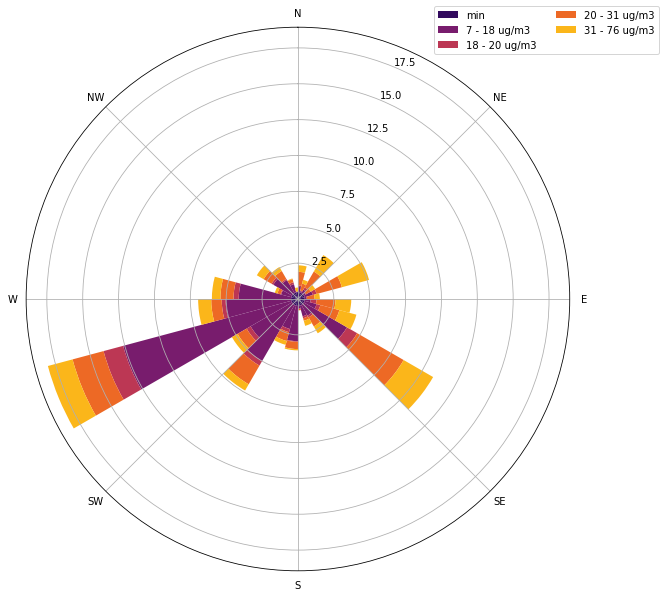

In [28]:
def NO2_labels(bins, units):   
    labels = []
    for left, right in zip(bins[:-1], bins[1:]):
        if left == bins[0]:
            labels.append('min'.format(right))
        elif np.isinf(right):
            labels.append('>{} {}'.format(left, units))
        else:
            labels.append('{} - {} {}'.format(left, right, units))

    return list(labels)

def _convert_dir(directions, N=None):
    if N is None:
        N = directions.shape[0]
    barDir = directions * np.pi/180. - np.pi/N
    barWidth = 2 * np.pi / N
    return barDir, barWidth

def aq_rose(rosedata, wind_dirs, palette=None):
    if palette is None:
        palette = sns.color_palette('inferno', n_colors=rosedata.shape[1])

    bar_dir, bar_width = _convert_dir(wind_dirs)

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    ax.set_theta_direction('clockwise')
    ax.set_theta_zero_location('N')

    for n, (c1, c2) in enumerate(zip(rosedata.columns[:-1], rosedata.columns[1:])):
        if n == 0:
            # first column only
            ax.bar(bar_dir, rosedata[c1].values, 
                   width=bar_width,
                   color=palette[0],
                   edgecolor='none',
                   label=c1,
                   linewidth=0)

        # all other columns
        ax.bar(bar_dir, rosedata[c2].values, 
               width=bar_width, 
               bottom=rosedata.cumsum(axis=1)[c1].values,
               color=palette[n+1],
               edgecolor='none',
               label=c2,
               linewidth=0)

    leg = ax.legend(loc=(0.75, 0.95), ncol=2)
    xtl = ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
    
    return fig

NO2_bins = [0,7,18,20,31,76]
NO2_labels = NO2_labels(NO2_bins, units='ug/m3')

dir_bins = np.arange(-7.5, 370, 15)
dir_labels = (dir_bins[:-1] + dir_bins[1:]) / 2

aqrose = (
    comp_df.assign(WindSpd_bins=lambda df:
            pd.cut(df['no2_avg'], bins=NO2_bins, labels=NO2_labels, right=True)
         )
        .assign(WindDir_bins=lambda df:
            pd.cut(df['wind_direction'], bins=dir_bins, labels=dir_labels, right=False)
         )
        .replace({'WindDir_bins': 360}, 0)
        .groupby(by=['WindSpd_bins', 'WindDir_bins'])
        .size()
        .unstack(level='WindSpd_bins')
        .fillna(0)
        .assign(min=lambda df: calm_count / df.shape[0])
        .sort_index(axis=1)
        .applymap(lambda x: x / total_count * 100)
)

directions = np.arange(0, 360, 15)
fig = aq_rose(aqrose, directions)

**Figure:** An air quality rose for Dublin Airport, showing the relationship between NO<sub>2</sub> concentrations and wind direction for the years 2011 to 2016.

In the graph above ‘Min’ is a value less than 7 µg/m<sup>2</sup>. The insight that we can take from the air quality rose is that higher concentrations of air pollutants are associated with winds that come easterly to northerly directions.

### Time lag

A characteristic of time series data, is the data may be strongly associated with a lagged copy of itself. This autoregression property of NO<sub>2</sub> concentrations was investigated by graphing a NO<sub>2</sub> data against a one day lag of itself, see following.

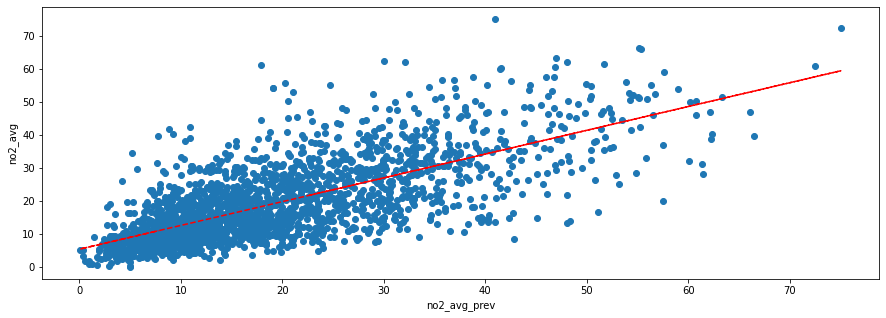

In [29]:
comp_df['no2_avg_prev'] = comp_df["no2_avg"].shift(1)
mydata = comp_df[['no2_avg_prev','no2_avg']]
mydata = mydata['2011-01-02':'2016-12-31']


x = mydata['no2_avg_prev']
y = mydata['no2_avg']
plt.scatter(x, y)

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.ylabel('no2_avg')
plt.xlabel('no2_avg_prev')
plt.show()

**Figure:** NO<sub>2</sub> and NO<sub>2</sub> one day lag, scatter plot 

From the previous figure we can see that there is a strong correlation between the two, meaning the previous NO<sub>2</sub> concentrations of the day can be used a strong predictor in our model to predict the NO<sub>2</sub> concentrations of the day. 

Finally, let’s generate a correlation matrix of the variables in our data, to get final insights into the relations between our variables and guide us in selecting the model to power the predictions. 

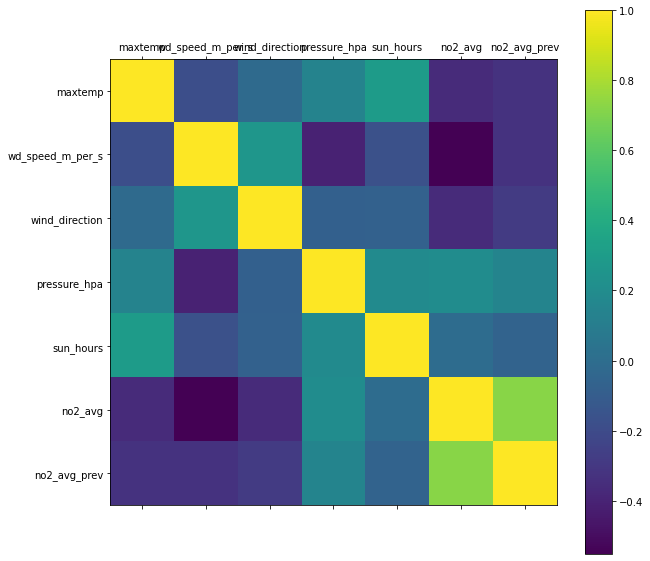

In [30]:
cor_cols = ['maxtemp', 'wd_speed_m_per_s', 'wind_direction','pressure_hpa', 'sun_hours','no2_avg','no2_avg_prev']

fig = plt.figure(figsize=(10,10))
im = plt.matshow(comp_df.loc[:, cor_cols].corr(), fignum=0)
fig.colorbar(im)
plt.xticks(range(len(cor_cols)), cor_cols)
plt.yticks(range(len(cor_cols)), cor_cols)
plt.show()


From this matrix, we can confirm that no2_avg and no2_avg_prev are strongly correlated (0.8), which makes sense because predicting air quality data is time-dependent, with the levels of polluants of the previous day impacting the next day. Interestingly, there is also a weak negative correlation between the NO<sub>2</sub> concentrations and the wind speed, which means that we can expect that when the wind speed increases, the NO<sub>2</sub> concentrations go down. This is also a result we can derive from the air quality rose. Most of the other variables are weakly correlated. 


### Summarizing the EDA
The exploratory data analysis of the weather and air pollution data has led to the following insights for our air quality monitoring site in Dublin:
 - As wind speed increase air quality improves.
 - As atmosphere pressure increases air quality decreases
 - Air quality is associated with wind direction. Easterly winds are associated with poorer air quality.
 - The time series of NO<sub>2</sub> is strongly associated with a time lagged version of itself.
 
From those insights, it is clear that we need to build our features with a lagged version of the NO<sub>2</sub>, and incorporate the wind and **atmosphere predictors** as features in our model. In our case, we will build a model to predict the NO<sub>2</sub> concentrations of any given day. The NO<sub>2</sub> is called the target variable in a machine learning setting. 

Generally speaking, we can follow two approaches when dealing with time-dependent data:
* A pure time-series approach, where the aim will be to forecast the target (NO<sub>2</sub>) based on the NO<sub>2</sub> value of the previous days and the other features of our data (wind speed, wind direction, and pressure). 
* A hybrid approach, where we use the features of our data as predictors of the NO<sub>2</sub> concentration, and incorporate some information about the relation in time of NO<sub>2</sub> (such as a lagged version of the NO<sub>2</sub>). 


## Step Four: Creating a machine learning model to predict air quality

To start small, we will follow the second approach, where we will build a model that will predict the NO<sub>2</sub> concentration of any given day based on wind speed, wind direction, maximum temperature, pressure values of that day, and the NO<sub>2</sub> concentration of the previous day. 

For this we will use the Linear Learner algorithm provided in Amazon SageMaker, enabling us to quickly build a model with minimal work. 

Our model will consist of taking all of the variables in our dataset, and using them as features to the Linear Learner algorithm available in Amazon SageMaker. 
However, before we can even start developing the model, we need to build a training and test set from our data. The training set will be used to train our model, while the test set will be used to evaluate the quality of the predictions of our model based on data the model has never seen. As our data is in time series format, we need to take extra care when splitting the data into our different sets. We want to train only on values that occur prior to the values in our test set, so we don’t bias our model with future observations. 

In our case, we used the data from years **2011 up to 2015 as training, and the year 2016 as our candidate year for testing and validating our model**.  

In [31]:
# Drop the 1st row as NaN
aq_df = comp_df.iloc[1:].copy()

# Adding wind_speed_direction, the product of wind_speed and the direction
aq_df["wind_speed_direction"] = aq_df.apply(lambda row: row['wd_speed_m_per_s'] * float(row['wind_direction']), axis=1)

In [32]:
aq_train_df = aq_df[aq_df.index.year < 2016]
aq_test_df = aq_df[aq_df.index.year == 2016]

In [33]:
x_train = aq_train_df.drop('no2_avg',1)
x_test = aq_test_df.drop('no2_avg',1)

y_train = aq_train_df[["no2_avg"]]
y_test = aq_test_df[["no2_avg"]]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_train.head())

(1825, 7) (1825, 1)
(366, 7) (366, 1)
                  maxtemp  wd_speed_m_per_s  wind_direction  pressure_hpa  \
observation_date                                                            
2011-01-02            3.1               3.1              50        1019.5   
2011-01-03            2.7               3.4             240        1012.4   
2011-01-04            5.4               8.4             260         997.2   
2011-01-05            5.8               7.1             240         984.1   
2011-01-06            3.5               3.8               0         987.8   

                  sun_hours  no2_avg_prev  wind_speed_direction  
observation_date                                                 
2011-01-02              0.0         22.67                 155.0  
2011-01-03              2.5         32.86                 816.0  
2011-01-04              0.0         31.62                2184.0  
2011-01-05              4.6         13.05                1704.0  
2011-01-06              4.

Next we define some helper functions to compute common forecasting metrics that will help us understand the performance of our model. 
Note here that we are using the sMAPE metric, which is often used to evaluate forecasting models and was used in 2018 as part of the KDD Air Quality Challenge.

In [25]:
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

# sMAPE is used in KDD Air Quality challenge: https://biendata.com/competition/kdd_2018/evaluation/ 
def smape(actual, predicted):
    dividend= np.abs(np.array(actual) - np.array(predicted))
    denominator = np.array(actual) + np.array(predicted)
    
    return 2 * np.mean(np.divide(dividend, denominator, out=np.zeros_like(dividend), where=denominator!=0, casting='unsafe'))

def print_metrics(y_test, y_pred):
    print("RMSE: %.4f" % sqrt(mean_squared_error(y_test, y_pred)))
    print('Variance score: %.4f' % r2_score(y_test, y_pred))
    print('Explained variance score: %.4f' % explained_variance_score(y_test, y_pred))
    forecast_err = np.array(y_test) - np.array(y_pred)
    print('Forecast bias: %.4f' % (np.sum(forecast_err) * 1.0/len(y_pred) ))
    print('sMAPE: %.4f' % smape(y_test, y_pred))

### LinearLearner on Amazon SageMaker

The Linear Learner algorithm is a simple yet powerful algorithm that can be used both for classification tasks (will tomorrow be sunny?) and regression tasks (what are tomorrow’s predicted NO<sub>2</sub> concentration levels?). In our case, we will use the regression setting of this algorithm. This will in turn be used to generate one-step ahead forecasts. 

The `LinearLearner` estimator in Amazon SageMaker requires you to input the Amazon SageMaker `role` that you created beforehand, which can be retrieved using the get_execution_role method. An important parameter in the estimator is to set it as a regression task, using the `predictor_type` parameter. It’s often required for machine learning algorithms to normalize and scale your data, in order to not induce your model into errors because of features in your models spanning different ranges or magnitude. Rather than doing this by hand, we can ask the Linear Learner estimator to do this for us when training, by setting to `True` the `normalize_data` and `normalize_label` parameters. 

We will train this model on a single *ml.c5.large* EC2 instance, see following code. The last two parameters of the following code specify where Amazon SageMaker can copy our training data in S3, and where to store the resulting model along with its learned parameters after the training. You will need to provide the name of an Amazon S3 bucket that you have created (the first parameter in the following code). The bucket must contain ‘sagemaker’ in the name, the name must be unique and it cannot contain uppercase letters or underscores. Your Amazon Sagemaker instance and Amazon S3 bucket need to be running in the same Amazon Web Services region.

In [4]:
from sagemaker import LinearLearner

data_location = 's3://{}/aq-linearlearner/data/train'.format(bucket)
output_location = 's3://{}/aq-linearlearner/output'.format(bucket)

llearner = LinearLearner(role=role,
                predictor_type='regressor',
                normalize_data=True,
                normalize_label=True,
                instance_count=1,
                instance_type='ml.c5.xlarge',
                output_path=output_location,
                data_location=data_location)


Now that we’ve understood how to initialize the Linear Learner estimator, we can call the fit function on it, which will launch the training process. In the call to fit, we give our training data captured in the `x_train` variable for the features, and the `y_train` variable for the target. 


In [27]:
%%time

llearner.fit([
    llearner.record_set(x_train.values.astype('float32'), y_train.values[:, 0].astype('float32'), channel='train'),
    llearner.record_set(x_test.values.astype('float32'), y_test.values[:, 0].astype('float32'), channel='test')
])

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2022-05-31 01:47:15 Starting - Starting the training job...
2022-05-31 01:47:39 Starting - Preparing the instances for trainingProfilerReport-1653961635: InProgress
......
2022-05-31 01:48:39 Downloading - Downloading input data...
2022-05-31 01:49:12 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[05/31/2022 01:49:23 INFO 139800578197312] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss': 'auto', 'margin': '1.0', 'quantile': '0.5', 'loss_insens

If you are following along and you already ran the call to fit, behind the scenes your training data was copied into the Amazon S3 bucket that we defined earlier. A training job in Amazon SageMaker has been launched, which is using the Linear Learner algorithm. In the output of the call to fit, we can see the training is running, trying to find the best parameters for our final model. 


One particular metric of interest is the **Mean Squared Error (MSE)** which will be different from across runs, but that gives us details about how well our model is performing. We get this metric because we supplied the test data in the call to fit. This can be particularly valuable as we iteratively build a better model. We can tweak the parameters of the algorithm, launch a new training job, and review its performance metrics until we are satisified with it. 


Go ahead and try different parameters in the estimator. For example, you could use the `num_models` parameter of the `LinearLearner` estimator to tweak how many models will be trained in parallel, enabling you to find solutions that may be more optimal by exploring variation of the parameters. If you want to go further, you can also use the Amazon SageMaker automatic model tuning to find the optimal parameters of your model optimized against a metric that you choose, for example the MSE that we find in the output of the training job. Because this is our baseline model, the current model is good enough for our use case, and we will now deploy our model into an endpoint to serve predictions to customers. 


Creating an endpoint that serves our model is simple in Amazon SageMaker. A single call to deploy using the estimator variable is enough. We will only be using the endpoint for predicting a single batch of values, so we can use a single *ml.t2.medium* EC2 instance. 

# Automatic Model Tuning With Hyperparameter Jobs

In [35]:
param_l1 = sagemaker.parameter.ContinuousParameter(1e-7, 
                                                   1,
                                                   scaling_type='Logarithmic')

param_wd = sagemaker.parameter.ContinuousParameter(1e-7, 
                                                   1,
                                                   scaling_type='Logarithmic')

param_learning_rate = sagemaker.parameter.ContinuousParameter(1e-5,
                                                             1,
                                                             scaling_type='Logarithmic')

hypertuner = sagemaker.tuner.HyperparameterTuner(llearner, 
                             objective_metric_name = 'test:mse', 
                             hyperparameter_ranges = {
                                               'l1' : param_l1,
                                               'wd' : param_wd,
                                               'learning_rate' : param_learning_rate,
                             }, 
                             metric_definitions=None, 
                             strategy='Bayesian', 
                             objective_type='Minimize', 
                             max_jobs=20, max_parallel_jobs=3,
                             early_stopping_type='Off'
                             )

In [ ]:
%%time

from datetime import datetime
datenow=datetime.now().strftime("%m%d%H%M%S")
job_name="aq-linearlearner-tune-"+datenow
print("job_name={}".format(job_name))

hypertuner.fit([
    llearner.record_set(x_train.values.astype('float32'), y_train.values[:, 0].astype('float32'), channel='train'),
    llearner.record_set(x_test.values.astype('float32'), y_test.values[:, 0].astype('float32'), channel='test')
], job_name=job_name)

job_name=aq-linearlearner-tune-0603194450


Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


.....................................................................................................................................................................................

In [28]:
from sagemaker.model_monitor import DataCaptureConfig

# prefix = "DEMO-ModelMonitor"
# data_capture_prefix = "{}/datacapture".format(prefix)
# s3_capture_upload_path = "s3://{}/{}".format(bucket, data_capture_prefix)
# reports_prefix = "{}/reports".format(prefix)
# s3_report_path = "s3://{}/{}".format(bucket, reports_prefix)

data_capture_config = DataCaptureConfig(
    enable_capture=True, sampling_percentage=100, destination_s3_uri=s3_capture_upload_path
)


In [29]:
from time import gmtime, strftime

endpoint_name = "DEMO-llearner-model-monitor-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("EndpointName={}".format(endpoint_name))

llearner_predictor = llearner.deploy(initial_instance_count=1,
                                 instance_type='ml.t2.medium',
                                 endpoint_name=endpoint_name,
                                 data_capture_config=data_capture_config)

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


EndpointName=DEMO-llearner-model-monitor-2022-05-31-01-49-58
-------------------!

Once the endpoint is up and running, we can serve predictions by sending data for which we want predictions by calling the predict method. 

In our case, we have already prepared data for that purpose, which is the the `x_test` variable, containing the features of our data except the target variable, which is the average NO2 concentrations of the day. 

In [30]:
result = llearner_predictor.predict(x_test.values.astype('float32'))

The call to predict should be a matter of a few seconds, and the resulting predictions will be saved in the result variable. 

To be able to get the actual predictions, there’s a slight work of data conversion and transformation to perform.

In [31]:
y_sm_pred = [r.label["score"].float32_tensor.values[0] for r in result]
y_sm_test = y_test.values[:, 0].astype('float32')

Let’s get the scores for our metrics based on our actual values and the predicted values. 

In [32]:
print_metrics(y_sm_test, y_sm_pred)

RMSE: 7.5963
Variance score: 0.5687
Explained variance score: 0.6814
Forecast bias: -3.8826
sMAPE: 0.3466


Now that we have the predictions for our test data, we will want to compare them to the actual expected values, also called the ground truth. To do this we can plot the predicted values against the ground truth, for our candidate test year of 2015.

In [33]:
y_sm_pred_df = pd.DataFrame(y_sm_pred, columns=y_train.columns).set_index(y_test.index).sort_index()
y_sm_test_df = pd.DataFrame(y_sm_test, columns=y_train.columns).set_index(y_test.index).sort_index()

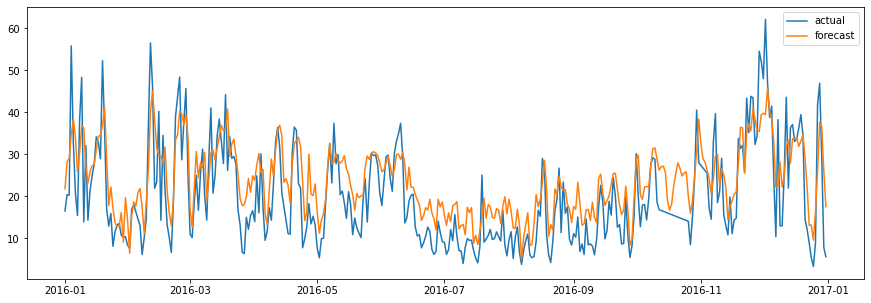

In [34]:
plt.plot(y_sm_test_df, label='actual')
plt.plot(y_sm_pred_df, label='forecast')
plt.legend()
plt.show()

Generally speaking, we can see that the model manages to capture the main trends of 2015, following the same progression over time as the ground truth. 

Among the metrics, we can see that the RMSE is quite low, but as the graph shows, we are making errors and not capturing all the information, especially the peaks. The variance is also well explained, with our model managing to explain a good part of the variance in our data. 

## Step Five: Invoke the deployed model
You can now send data to this endpoint to get inferences in real time. Because you enabled the data capture in the previous steps, the request and response payload, along with some additional metadata, is saved in the Amazon Simple Storage Service (Amazon S3) location you have specified in the DataCaptureConfig.

This step invokes the endpoint with included sample data for about 3 minutes. Data is captured based on the sampling percentage specified and the capture continues until the data capture option is turned off.

In [35]:
x_test

,maxtemp,wd_speed_m_per_s,wind_direction,pressure_hpa,sun_hours,no2_avg_prev,wind_speed_direction
observation_date,,,,,,,
2016-01-01,8.3,9.0,130,995.1,0.0,11.45,1170.0
2016-01-02,10.2,4.9,110,986.2,0.3,16.52,539.0
2016-01-03,10.5,5.4,120,976.2,3.5,20.39,648.0
2016-01-04,9.2,1.6,140,966.3,4.3,20.30,224.0
2016-01-05,7.1,5.2,330,975.6,0.3,55.83,1716.0
...,...,...,...,...,...,...,...
2016-12-27,8.4,3.0,170,1030.1,1.5,8.79,510.0
2016-12-28,11.4,1.8,150,1026.8,6.7,41.89,270.0
2016-12-29,9.8,3.5,230,1022.4,0.0,46.93,805.0


In [36]:
import time

# Get a subset of test data for a quick test
print("Sending test traffic to the endpoint {}. \nPlease wait...".format(endpoint_name))

for i in range(x_test.shape[0]):
    row = x_test.iloc[i].values.astype('float32')
#     print(row)
    response = llearner_predictor.predict(row)
#     print(response)
    time.sleep(0.1)

print("Done!")

Sending test traffic to the endpoint DEMO-llearner-model-monitor-2022-05-31-01-49-58. 
Please wait...
Done!


### View captured data
Now list the data capture files stored in Amazon S3. You should expect to see different files from different time periods organized based on the hour in which the invocation occurred. The format of the Amazon S3 path is:

s3://{destination-bucket-prefix}/{endpoint-name}/{variant-name}/yyyy/mm/dd/hh/filename.jsonl



In [38]:
s3_client = boto3.Session().client("s3")
current_endpoint_capture_prefix = "{}/{}".format(data_capture_prefix, endpoint_name)
result = s3_client.list_objects(Bucket=bucket, Prefix=current_endpoint_capture_prefix)
capture_files = [capture_file.get("Key") for capture_file in result.get("Contents")]
print("Found Capture Files:")
print("\n ".join(capture_files))

Found Capture Files:
sagemaker/DEMO-ModelMonitor/datacapture/DEMO-llearner-model-monitor-2022-05-31-01-49-58/AllTraffic/2022/05/31/01/59-31-260-f1ee0008-c99d-43cb-b52d-1212e96c25db.jsonl
 sagemaker/DEMO-ModelMonitor/datacapture/DEMO-llearner-model-monitor-2022-05-31-01-49-58/AllTraffic/2022/05/31/02/00-31-355-84226737-f0af-4a86-9be8-5289953191cd.jsonl


In [39]:
def get_obj_body(obj_key):
    return s3_client.get_object(Bucket=bucket, Key=obj_key).get("Body").read().decode("utf-8")


capture_file = get_obj_body(capture_files[-1])
print(capture_file[:2000])

{"captureData":{"endpointInput":{"observedContentType":"application/x-recordio-protobuf","mode":"INPUT","data":"CiPXziwAAAAKKgoGdmFsdWVzEiASHgoczcwkQZqZ6UAAAGZDAIB9RM3MzD/D9fhAAODRRA==","encoding":"BASE64"},"endpointOutput":{"observedContentType":"application/x-recordio-protobuf","mode":"OUTPUT","data":"CiPXzhMAAAASEQoFc2NvcmUSCBIGCgQUboxBAA==","encoding":"BASE64"}},"eventMetadata":{"eventId":"69fc002b-34d6-4a2f-9dca-be0fa4012b0d","inferenceTime":"2022-05-31T02:00:31Z"},"eventVersion":"0"}



### Pretty print of JSON

In [40]:
import json

print(json.dumps(json.loads(capture_file.split("\n")[0]), indent=2))

{
  "captureData": {
    "endpointInput": {
      "observedContentType": "application/x-recordio-protobuf",
      "mode": "INPUT",
      "data": "CiPXziwAAAAKKgoGdmFsdWVzEiASHgoczcwkQZqZ6UAAAGZDAIB9RM3MzD/D9fhAAODRRA==",
      "encoding": "BASE64"
    },
    "endpointOutput": {
      "observedContentType": "application/x-recordio-protobuf",
      "mode": "OUTPUT",
      "data": "CiPXzhMAAAASEQoFc2NvcmUSCBIGCgQUboxBAA==",
      "encoding": "BASE64"
    }
  },
  "eventMetadata": {
    "eventId": "69fc002b-34d6-4a2f-9dca-be0fa4012b0d",
    "inferenceTime": "2022-05-31T02:00:31Z"
  },
  "eventVersion": "0"
}


As you can see, each inference request is captured in one line in the jsonl file. The line contains both the input and output merged together. In the example, you provided the ContentType as text/csv which is reflected in the observedContentType value. Also, you expose the encoding that you used to encode the input and output payloads in the capture format with the encoding value.

To recap, you observed how you can enable capturing the input or output payloads to an endpoint with a new parameter. You have also observed what the captured format looks like in Amazon S3. Next, continue to explore how Amazon SageMaker helps with monitoring the data collected in Amazon S3.

# Step Six: Model Monitor - Baselining and continuous monitoring

In addition to collecting the data, Amazon SageMaker provides the capability for you to monitor and evaluate the data observed by the endpoints. For this:

Create a baseline with which you compare the realtime traffic.
Once a baseline is ready, setup a schedule to continously evaluate and compare against the baseline.
1. Constraint suggestion with baseline/training dataset
The training dataset with which you trained the model is usually a good baseline dataset. Note that the training dataset data schema and the inference dataset schema should exactly match (i.e. the number and order of the features).

From the training dataset you can ask Amazon SageMaker to suggest a set of baseline constraints and generate descriptive statistics to explore the data. For this example, upload the training dataset that was used to train the pre-trained model included in this example. If you already have it in Amazon S3, you can directly point to it.

In [41]:
# copy over the training dataset to Amazon S3 (if you already have it in Amazon S3, you could reuse it)
baseline_prefix = prefix + "/baselining"
baseline_data_prefix = baseline_prefix + "/data"
baseline_results_prefix = baseline_prefix + "/results"

baseline_data_uri = "s3://{}/{}".format(bucket, baseline_data_prefix)
baseline_results_uri = "s3://{}/{}".format(bucket, baseline_results_prefix)
print("Baseline data uri: {}".format(baseline_data_uri))
print("Baseline results uri: {}".format(baseline_results_uri))

Baseline data uri: s3://sagemaker-model-monitor-praveena/sagemaker/DEMO-ModelMonitor/baselining/data
Baseline results uri: s3://sagemaker-model-monitor-praveena/sagemaker/DEMO-ModelMonitor/baselining/results


In [42]:
aq_train_df.to_csv("./training-dataset-with-header.csv")

In [43]:
import os
import boto3

training_data_file = open("./training-dataset-with-header.csv", "rb")
s3_key = os.path.join(baseline_prefix, "data", "training-dataset-with-header.csv")
boto3.Session().resource("s3").Bucket(bucket).Object(s3_key).upload_fileobj(training_data_file)

### Create a baselining job with training dataset
Now that you have the training data ready in Amazon S3, start a job to suggest constraints. DefaultModelMonitor.suggest_baseline(..) starts a ProcessingJob using an Amazon SageMaker provided Model Monitor container to generate the constraints.

In [ ]:
from sagemaker.model_monitor import DefaultModelMonitor
from sagemaker.model_monitor.dataset_format import DatasetFormat

my_default_monitor = DefaultModelMonitor(
    role=role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    volume_size_in_gb=20,
    max_runtime_in_seconds=3600,
)

my_default_monitor.suggest_baseline(
    baseline_dataset=baseline_data_uri + "/training-dataset-with-header.csv",
    dataset_format=DatasetFormat.csv(header=True),
    output_s3_uri=baseline_results_uri,
    wait=True,
)

## Explore the generated constraints and statistics


In [45]:
s3_client = boto3.Session().client("s3")
result = s3_client.list_objects(Bucket=bucket, Prefix=baseline_results_prefix)
report_files = [report_file.get("Key") for report_file in result.get("Contents")]
print("Found Files:")
print("\n ".join(report_files))

Found Files:
sagemaker/DEMO-ModelMonitor/baselining/results/constraints.json
 sagemaker/DEMO-ModelMonitor/baselining/results/statistics.json


In [46]:
import pandas as pd

baseline_job = my_default_monitor.latest_baselining_job
schema_df = pd.io.json.json_normalize(baseline_job.baseline_statistics().body_dict["features"])
schema_df.head(10)


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


,name,inferred_type,string_statistics.common.num_present,string_statistics.common.num_missing,string_statistics.distinct_count,numerical_statistics.common.num_present,numerical_statistics.common.num_missing,numerical_statistics.mean,numerical_statistics.sum,numerical_statistics.std_dev,numerical_statistics.min,numerical_statistics.max,numerical_statistics.distribution.kll.buckets,numerical_statistics.distribution.kll.sketch.parameters.c,numerical_statistics.distribution.kll.sketch.parameters.k,numerical_statistics.distribution.kll.sketch.data
0,observation_date,String,1825.0,0.0,1815.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,maxtemp,Fractional,NaN,NaN,NaN,1825.0,0.0,13.382685,24423.40,4.717288,1.90,26.20,"[{'lower_bound': 1.9, 'upper_bound': 4.33, 'co...",0.64,2048.0,"[[3.1, 2.7, 5.4, 5.8, 3.5, 4.6, 3.8, 5.2, 8.6,..."
2,wd_speed_m_per_s,Fractional,NaN,NaN,NaN,1825.0,0.0,5.671014,10349.60,2.331450,1.20,14.80,"[{'lower_bound': 1.2, 'upper_bound': 2.56, 'co...",0.64,2048.0,"[[3.1, 3.4, 8.4, 7.1, 3.8, 4.6, 8.3, 6.2, 4.5,..."
3,wind_direction,Integral,NaN,NaN,NaN,1825.0,0.0,204.421918,373070.00,81.882024,0.00,360.00,"[{'lower_bound': 0.0, 'upper_bound': 36.0, 'co...",0.64,2048.0,"[[50.0, 240.0, 260.0, 240.0, 0.0, 80.0, 260.0,..."
4,pressure_hpa,Fractional,NaN,NaN,NaN,1825.0,0.0,1002.665973,1829865.40,11.652319,951.00,1031.40,"[{'lower_bound': 951.0, 'upper_bound': 959.04,...",0.64,2048.0,"[[1019.5, 1012.4, 997.2, 984.1, 987.8, 985.4, ..."
5,sun_hours,Fractional,NaN,NaN,NaN,1825.0,0.0,4.161096,7594.00,3.754138,0.00,15.70,"[{'lower_bound': 0.0, 'upper_bound': 1.5699999...",0.64,2048.0,"[[0.0, 2.5, 0.0, 4.6, 4.2, 0.3, 4.6, 5.8, 0.0,..."
6,no2_avg,Fractional,NaN,NaN,NaN,1825.0,0.0,18.953238,34589.66,12.301318,0.04,75.05,"[{'lower_bound': 0.04, 'upper_bound': 7.540999...",0.64,2048.0,"[[32.86, 31.62, 13.05, 24.67, 55.11, 51.09, 16..."
7,no2_avg_prev,Fractional,NaN,NaN,NaN,1825.0,0.0,18.959386,34600.88,12.300371,0.04,75.05,"[{'lower_bound': 0.04, 'upper_bound': 7.540999...",0.64,2048.0,"[[22.67, 32.86, 31.62, 13.05, 24.67, 55.11, 51..."
8,wind_speed_direction,Fractional,NaN,NaN,NaN,1825.0,0.0,1208.408767,2205346.00,731.616217,0.00,3552.00,"[{'lower_bound': 0.0, 'upper_bound': 355.2, 'c...",0.64,2048.0,"[[155.0, 816.0, 2184.0, 1704.0, 0.0, 368.0, 21..."


# Analyze collected data for data quality issues

In [48]:
mon_schedule_name = "DEMO-llinear-pred-model-monitor-schedule-" + strftime(
    "%Y-%m-%d-%H-%M-%S", gmtime()
)

print(mon_schedule_name)
print(s3_report_path)

DEMO-llinear-pred-model-monitor-schedule-2022-05-31-02-10-09
s3://sagemaker-model-monitor-praveena/sagemaker/DEMO-ModelMonitor/reports


In [49]:
from sagemaker.model_monitor import CronExpressionGenerator

# reports_prefix = "{}/reports".format(prefix)
# s3_report_path = "s3://{}/{}".format(bucket, reports_prefix)

my_default_monitor.create_monitoring_schedule(
    monitor_schedule_name=mon_schedule_name,
    endpoint_input=llearner_predictor.endpoint,
    # record_preprocessor_script=pre_processor_script,
    output_s3_uri=s3_report_path,
    statistics=my_default_monitor.baseline_statistics(),
    constraints=my_default_monitor.suggested_constraints(),
    schedule_cron_expression=CronExpressionGenerator.hourly(),
    enable_cloudwatch_metrics=True,
)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


### Start generating some artificial traffic
The cell below starts a thread to send some traffic to the endpoint. Note that you need to stop the kernel to terminate this thread. If there is no traffic, the monitoring jobs are marked as Failed since there is no data to process.

In [50]:
x_test.to_csv("./test-dataset-input-cols.csv")

In [ ]:
# Send traffic all at once

for i in range(x_test.shape[0]):
    row = x_test.iloc[i].values.astype('float32')
#     print(row)
    response = llearner_predictor.predict(row)
#     print(response)
    time.sleep(0.1)
    
print("DONE")

In [51]:
# Send traffic on a background thread continuously.

import sagemaker

from threading import Thread
from time import sleep

endpoint_name = llearner_predictor.endpoint
runtime_client = sm_session.sagemaker_runtime_client

# (just repeating code from above for convenience/ able to run this section independently)
def invoke_endpoint(ep_name, file_name, runtime_client):
    with open(file_name, "r") as f:
        for row in f:
            payload = row.rstrip("\n")
            response = runtime_client.invoke_endpoint(
                EndpointName=ep_name, ContentType="text/csv", Body=payload
            )
            response["Body"].read()
            time.sleep(1)

def invoke_api():
    for i in range(x_test.shape[0]):
        row = x_test.iloc[i].values.astype('float32')
    #     print(row)
        response = llearner_predictor.predict(row)
    #     print(response)
        time.sleep(1)

def invoke_endpoint_forever():
    while True:
        try:
#             invoke_endpoint(endpoint_name, "./test-dataset-input-cols.csv", runtime_client)
            invoke_api()
        except runtime_client.exceptions.ValidationError:
            pass


thread = Thread(target=invoke_endpoint_forever)
thread.start()

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [61]:
desc_schedule_result = my_default_monitor.describe_schedule()
print("Schedule status: {}".format(desc_schedule_result["MonitoringScheduleStatus"]))

Schedule status: Scheduled


In [ ]:
mon_executions = my_default_monitor.list_executions()
print(
    "We created a hourly schedule above that begins executions ON the hour (plus 0-20 min buffer.\nWe will have to wait till we hit the hour..."
)

while len(mon_executions) == 0:
    print("Waiting for the first execution to happen...")
    time.sleep(60)
    mon_executions = my_default_monitor.list_executions()

No executions found for schedule. monitoring_schedule_name: DEMO-llinear-pred-model-monitor-schedule-2022-05-31-02-10-09
We created a hourly schedule above that begins executions ON the hour (plus 0-20 min buffer.
We will have to wait till we hit the hour...
Waiting for the first execution to happen...
No executions found for schedule. monitoring_schedule_name: DEMO-llinear-pred-model-monitor-schedule-2022-05-31-02-10-09
Waiting for the first execution to happen...
No executions found for schedule. monitoring_schedule_name: DEMO-llinear-pred-model-monitor-schedule-2022-05-31-02-10-09
Waiting for the first execution to happen...
No executions found for schedule. monitoring_schedule_name: DEMO-llinear-pred-model-monitor-schedule-2022-05-31-02-10-09
Waiting for the first execution to happen...


In [ ]:
latest_execution = mon_executions[-1]  # Latest execution's index is -1, second to last is -2, etc
# time.sleep(60)
# latest_execution.wait(logs=False)

print("Latest execution status: {}".format(latest_execution.describe()["ProcessingJobStatus"]))
print("Latest execution result: {}".format(latest_execution.describe()["ExitMessage"]))

latest_job = latest_execution.describe()
if latest_job["ProcessingJobStatus"] != "Completed":
    print(
        "====STOP==== \n No completed executions to inspect further. Please wait till an execution completes or investigate previously reported failures."
    )


In [ ]:
violations = my_default_monitor.latest_monitoring_constraint_violations()
pd.set_option("display.max_colwidth", None)
constraints_df = pd.io.json.json_normalize(violations.body_dict["violations"])
constraints_df.head(10)

# Create Cloud Watch Alarms

In [ ]:
cw_client = boto3.Session().client('cloudwatch')

alarm_name='BASELINE_DRIFT_FEATURE_'
alarm_desc='Trigger an cloudwatch alarm when the feature age drifts away from the baseline'
feature_age_drift_threshold=0.1 ##Setting this threshold purposefully slow to see the alarm quickly.
metric_name='feature_baseline_drift'
namespace='aws/sagemaker/Endpoints/data-metrics'

endpoint_name=endpoint_name
monitoring_schedule_name=mon_schedule_name

cw_client.put_metric_alarm(
    AlarmName=alarm_name,
    AlarmDescription=alarm_desc,
    ActionsEnabled=True,
    AlarmActions=[sns_notifications_topic],
    MetricName=metric_name,
    Namespace=namespace,
    Statistic='Average',
    Dimensions=[
        {
            'Name': 'Endpoint',
            'Value': endpoint_name
        },
        {
            'Name': 'MonitoringSchedule',
            'Value': monitoring_schedule_name
        }
    ],
    Period=600,
    EvaluationPeriods=1,
    DatapointsToAlarm=1,
    Threshold=feature_age_drift_threshold,
    ComparisonOperator='GreaterThanOrEqualToThreshold',
    TreatMissingData='breaching'
)

## Delete resources

In [ ]:
# Retrieve name of resources created
client = llearner_predictor.sagemaker_session.sagemaker_client
model_name = client.describe_endpoint_config(
    EndpointConfigName=llearner.latest_training_job.job_name)['ProductionVariants'][0]['ModelName']
endpoint_config_name = llearner.latest_training_job.job_name # Same as training job name
endpoint_name = llearner.latest_training_job.job_name # Same as training job name

# Delete resources
client.delete_endpoint(EndpointName=endpoint_name)
client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
client.delete_model(ModelName=model_name)

## Acknowledgements


### Irish Weather Data:
Met Éireann retains Intellectual Property Rights and copyright over our data. If data are published in raw or processed format Met Éireann must be acknowledged as the source. Met Éireann does not accept any liability whatsoever for any error or omission in the data series, their availability, or for any loss or damage arising from their use. This work is licensed under a Creative Commons Attribution 4.0 International (CC BY 4.0) License.

### Irish Air Quality Data:
EPA,"EPA Ireland Archive of Nitrogen Oxides Monitoring Data". Associated datasets and digitial information objects connected to this resource are available at: Secure Archive For Environmental Research Data (SAFER) managed by Environmental Protection Agency Ireland http://erc.epa.ie/safer/resource?id=216a8992-76e5-102b-aa08-55a7497570d3 (Last Accessed: 2018-06-30) (both require as their data usage license that they be credited)

### Wind Rose Code
The Air Quality Rose was adapted from Wind Rose code that was published on GitHub under a BSD-license:
https://github.com/Geosyntec/cloudside

The air quality rose is based on a function called "rose" is in the viz.py submodule:
https://github.com/Geosyntec/cloudside/blob/master/cloudside/viz.py#L370

